In [1]:
# Step 1: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.applications import VGG16, DenseNet201, Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# Step 2: Enhance Image with CLAHE
def enhance_image(image_array):
    lab = cv2.cvtColor(image_array, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return enhanced

In [3]:
# Step 3: Load and Preprocess Data with CLAHE
def load_images_and_labels(dataset_path, img_size=(224, 224)):
    categories = ['benign', 'malignant']
    data = []
    labels = []

    for category in categories:
        folder_path = os.path.join(dataset_path, category)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(file_path).convert("RGB")
                img = img.resize(img_size)
                enhanced = enhance_image(np.array(img))
                data.append(enhanced)
                labels.append(category)
            except:
                continue
    return np.array(data), np.array(labels)

In [4]:
path = r"C:\Users\LLR User\Desktop\Coding\code\skin-cancer\Dataset"  # Full path
X, y_labels = load_images_and_labels(path)

In [5]:
# Step 5: Normalization using dataset mean and std
mean = np.mean(X, axis=(0, 1, 2), keepdims=True, dtype=np.float32)
std = np.std(X, axis=(0, 1, 2), keepdims=True, dtype=np.float32)
std[std == 0] = 1e-6  # Avoid division by zero
X = (X - mean) / std

In [6]:
# Encode labels
y = LabelEncoder().fit_transform(y_labels)
y_cat = to_categorical(y, num_classes=2)


In [7]:
# Step 6: Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)


In [8]:
# Step 6: Data Generators
train_aug = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

val_aug = ImageDataGenerator()

train_gen = train_aug.flow(X_train, y_train, batch_size=8)
val_gen = val_aug.flow(X_test, y_test, batch_size=8)


In [9]:
def build_transfer_model(base_model, input_shape=(224,224,3)):
    base = base_model(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
# Visualization Helpers
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

def plot_learning_curves(history, title):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



🔧 Training model: VGG16


c:\Users\LLR User\miniconda3\envs\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.5012 - loss: 0.7822 - val_accuracy: 0.7109 - val_loss: 0.6413
Epoch 2/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.6088 - loss: 0.6653 - val_accuracy: 0.7867 - val_loss: 0.5766
Epoch 3/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.6946 - loss: 0.5903 - val_accuracy: 0.7915 - val_loss: 0.5333
Epoch 4/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.7632 - loss: 0.5315 - val_accuracy: 0.7630 - val_loss: 0.5032
Epoch 5/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.7549 - loss: 0.5160 - val_accuracy: 0.7464 - val_loss: 0.4917
14/14 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step


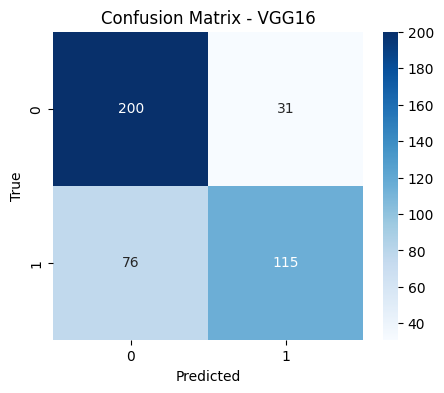

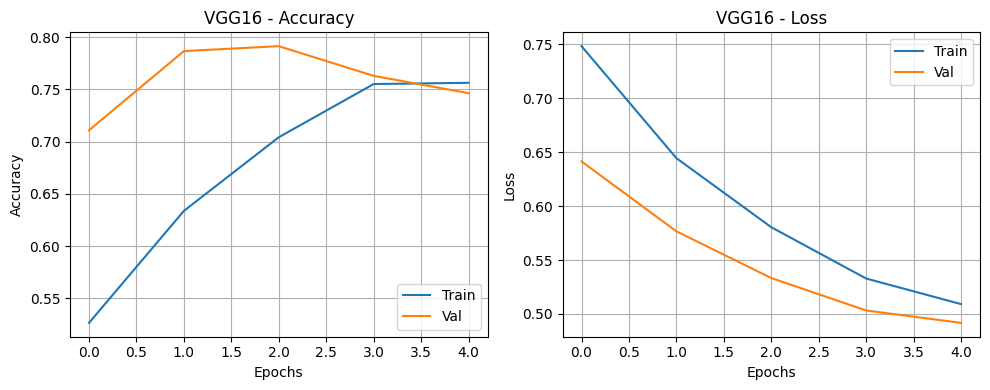


✅ VGG16 Accuracy: 0.7464

📋 VGG16 Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.87      0.79       231
           1       0.79      0.60      0.68       191

    accuracy                           0.75       422
   macro avg       0.76      0.73      0.74       422
weighted avg       0.75      0.75      0.74       422


🔧 Training model: DenseNet201
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.5892 - loss: 0.8224 - val_accuracy: 0.7038 - val_loss: 0.5021
Epoch 2/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 200s 947ms/step - accuracy: 0.7412 - loss: 0.5103 - val_accuracy: 0.7227 - val_loss: 0.5052
Epoch 3/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 196s 929ms/step - accuracy: 0.7779 - loss: 0.4633 - val_accuracy: 0.7370 - val_loss: 0.4873
Epoch 4/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 196s 930ms/step - accuracy: 0.7625 - loss: 0.4640 - val_accuracy: 0.7630 - val_loss: 0.4498
Epoch 5/5
21

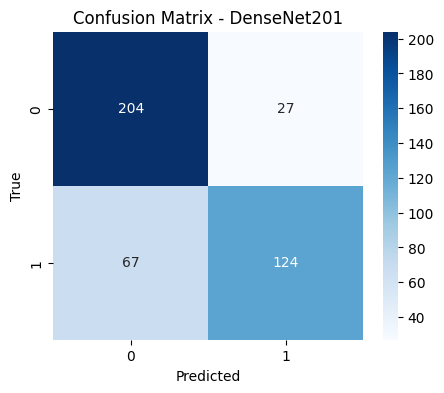

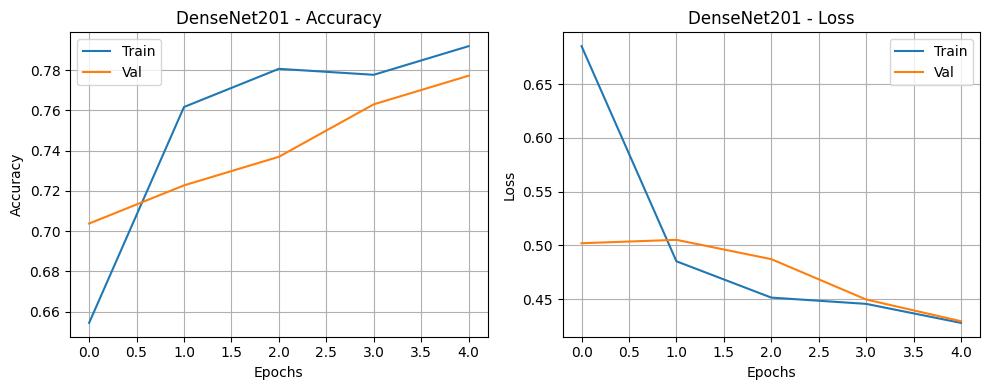


✅ DenseNet201 Accuracy: 0.7773

📋 DenseNet201 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       231
           1       0.82      0.65      0.73       191

    accuracy                           0.78       422
   macro avg       0.79      0.77      0.77       422
weighted avg       0.78      0.78      0.77       422


🔧 Training model: Xception
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 160s 736ms/step - accuracy: 0.5979 - loss: 0.6818 - val_accuracy: 0.6967 - val_loss: 0.5495
Epoch 2/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 190s 901ms/step - accuracy: 0.7004 - loss: 0.5554 - val_accuracy: 0.7536 - val_loss: 0.4671
Epoch 3/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 166s 731ms/step - accuracy: 0.7629 - loss: 0.5117 - val_accuracy: 0.7512 - val_loss: 0.4661
Epoch 4/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 152s 723ms/step - accuracy: 0.7521 - loss: 0.5113 - val_accuracy: 0.7583 - val_loss: 0.4509


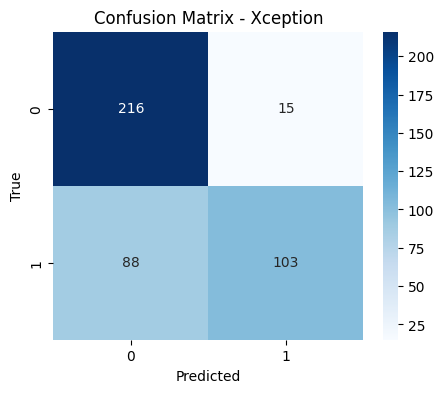

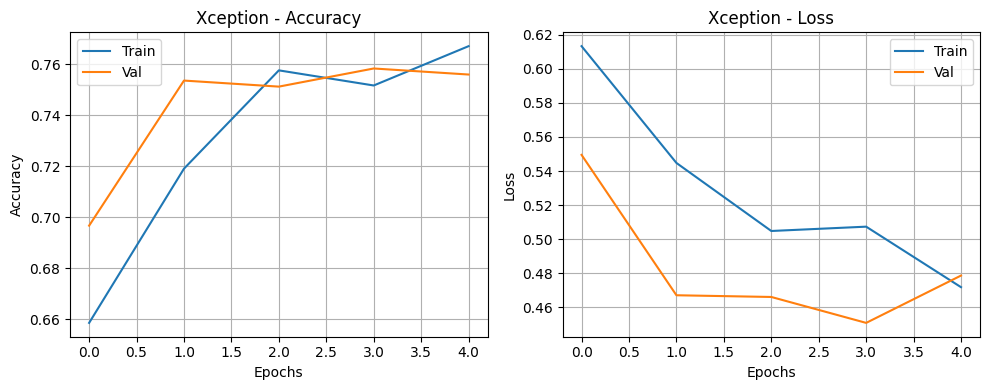


✅ Xception Accuracy: 0.7559

📋 Xception Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.94      0.81       231
           1       0.87      0.54      0.67       191

    accuracy                           0.76       422
   macro avg       0.79      0.74      0.74       422
weighted avg       0.78      0.76      0.74       422



In [11]:
# Train and Compare Models
architectures = {
    "VGG16": VGG16,
    "DenseNet201": DenseNet201,
    "Xception": Xception
}

results = {}

for name, base_model in architectures.items():
    print(f"\n🔧 Training model: {name}")
    model = build_transfer_model(base_model)
    history = model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=1)

    results[name] = {"model": model, "history": history}

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    plot_confusion_matrix(y_true, y_pred_classes, name)
    plot_learning_curves(history, name)

    acc = accuracy_score(y_true, y_pred_classes)
    print(f"\n✅ {name} Accuracy: {acc:.4f}")
    print(f"\n📋 {name} Classification Report:")
    print(classification_report(y_true, y_pred_classes))


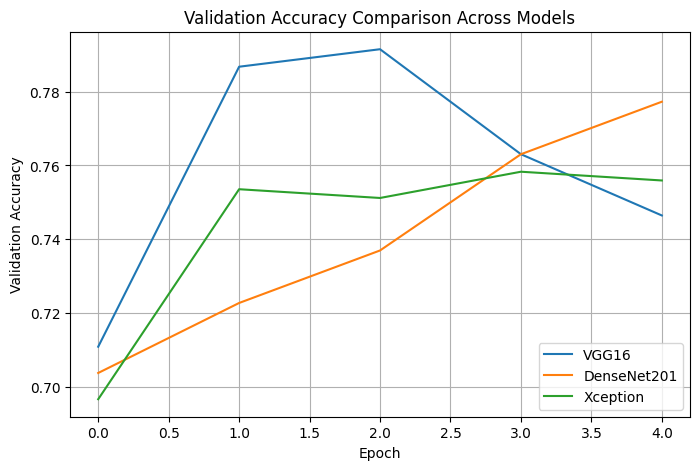

In [12]:
# Step 8: Compare All Models
plt.figure(figsize=(8, 5))
for name, result in results.items():
    val_acc = result['history'].history['val_accuracy']
    plt.plot(val_acc, label=name)

plt.title('Validation Accuracy Comparison Across Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
